In [1]:
 
import numpy as np 
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import shap

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
pip install tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.0/227.0 MB 9.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 41.3 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 41.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 34.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.8/389.8 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 37.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 38.1 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0


In [3]:
pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.2/455.2 kB 6.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np 
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import shap


In [6]:
champs = pd.read_csv(r"/Users/kanak/Downloads/champs.csv")
matches = pd.read_csv(r"/Users/kanak/Downloads/matches.csv")
participants = pd.read_csv(r"/Users/kanak/Downloads/participants.csv")
stats1 = pd.read_csv(r"/Users/kanak/Downloads/stats1.csv")
stats2 = pd.read_csv(r"/Users/kanak/Downloads/stats2.csv")
teamstats = pd.read_csv(r"/Users/kanak/Downloads/teamstats.csv")


/var/folders/lj/0v3ws1212_bdp9pz4mzxdkvw0000gn/T/ipykernel_62057/593585418.py:5: DtypeWarning: Columns (52) have mixed types. Specify dtype option on import or set low_memory=False.
  stats2 = pd.read_csv(r"/Users/kanak/Downloads/stats2.csv", dtype={'column_name': 'str'})  # Replace 'column_name' with the name of the problematic column


In [7]:
def bot_pos(row):
    if row.position == "BOT":
        if row.role == 'DUO_SUPPORT':
            row.position = "SUPP"
        else:
            row.position = "ADC"
    return row

participants = participants.apply(bot_pos, axis = "columns")
participants.loc[:,["position","role"]]

,position,role
0,JUNGLE,NONE
1,SUPP,DUO_SUPPORT
2,ADC,DUO_CARRY
3,TOP,SOLO
4,MID,SOLO
...,...,...
1834515,ADC,DUO_CARRY
1834516,MID,SOLO
1834517,SUPP,DUO_SUPPORT
1834518,JUNGLE,NONE


In [9]:
participants = participants.apply(bot_pos, axis="columns")

In [11]:
participants["teamid"] = participants.player.apply(lambda x: 100 if x<= 5 else 200)
stats_merged = pd.concat([stats1,stats2])
train_data = pd.merge(participants,stats_merged, on = "id")
train_data = pd.merge(train_data, teamstats.drop(["firstblood"],axis=1), on = ["matchid","teamid"])

train_data = train_data.drop(["id","matchid","teamid","player"], axis=1)
train_data.head()

# saves a copy of the merged dataset
train_data.to_csv('merged_data.csv', index = False)

The correlation between ChampionID and its Winrate is -0.05703197306937949


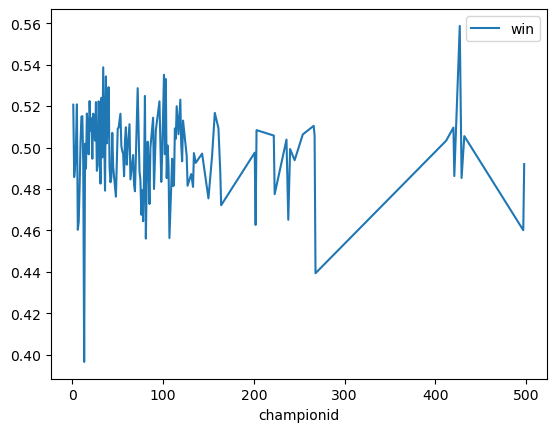

In [12]:
ChampionWinrate = train_data[["championid","win"]].groupby(["championid"], as_index = False).mean()
ChampionWinrate.plot("championid","win")
print("The correlation between ChampionID and its Winrate is " + str(ChampionWinrate.corr().championid.win))

In [13]:
train_data[["position",'win']].groupby(["position"], as_index = False).mean()

,position,win
0,ADC,0.497815
1,JUNGLE,0.500398
2,MID,0.494621
3,SUPP,0.506444
4,TOP,0.501536


In [14]:
train_data[["role",'win']].groupby(["role"], as_index = False).mean()


,role,win
0,DUO,0.421546
1,DUO_CARRY,0.505416
2,DUO_SUPPORT,0.505418
3,NONE,0.499136
4,SOLO,0.501889


position
ADC       0.510536
JUNGLE    0.864870
MID       0.735480
SUPP      0.287877
TOP       0.125670
dtype: float64

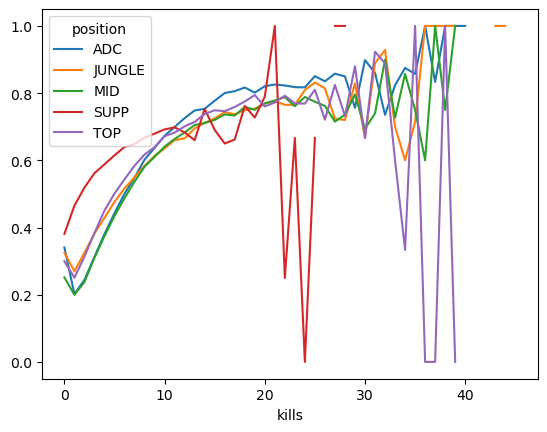

In [15]:
KillsWinrate = train_data[["position","kills",'win']].groupby(["position","kills"], as_index = False).mean()
KillsWinrate = KillsWinrate.pivot(index="kills", columns='position', values='win')
KillsWinrate.plot()
KillsWinrate.corrwith(KillsWinrate.reset_index().kills)

position
ADC      -0.857612
JUNGLE   -0.542511
MID      -0.694104
SUPP     -0.846589
TOP      -0.391751
dtype: float64

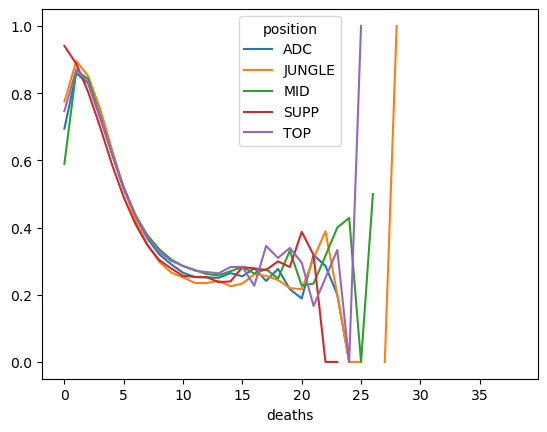

In [16]:
DeathsWinrate = train_data[["position","deaths",'win']].groupby(["position","deaths"], as_index = False).mean()
DeathsWinrate = DeathsWinrate.pivot(index="deaths", columns='position', values='win')
DeathsWinrate.plot()
DeathsWinrate.corrwith(DeathsWinrate.reset_index().deaths)

position
ADC       0.631812
JUNGLE    0.903122
MID       0.325766
SUPP      0.756937
TOP       0.806263
dtype: float64

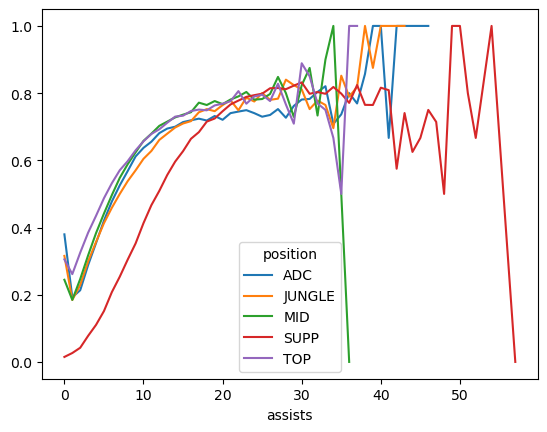

In [17]:
AssistsWinrate = train_data[["position","assists",'win']].groupby(["position","assists"], as_index = False).mean()
AssistsWinrate = AssistsWinrate.pivot(index="assists", columns='position', values='win')
AssistsWinrate.plot()
AssistsWinrate.corrwith(AssistsWinrate.reset_index().assists)

In [20]:
train_data["KDA"] = train_data.apply(lambda x: (x.kills + x.assists) / max(x.deaths,1), axis = "columns")

KDAWinrate = train_data[["position","KDA",'win']].groupby(["position","KDA"], as_index = False).mean()
KDAWinrate = KDAWinrate.pivot(index="KDA", columns='position', values='win')
KDAWinrate.corrwith(KDAWinrate.reset_index().KDA)

position
ADC       0.568924
JUNGLE    0.572268
MID       0.561061
SUPP      0.595511
TOP       0.499867
dtype: float64

<Axes: xlabel='KDA'>

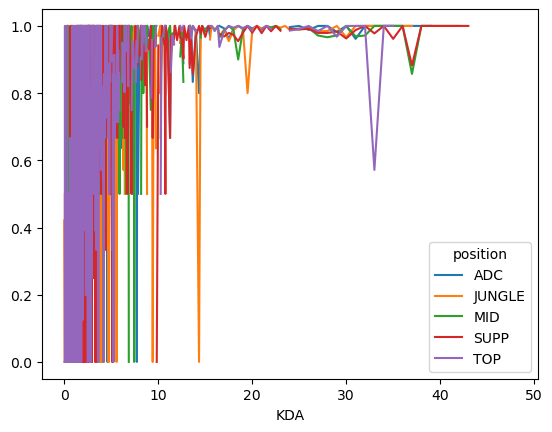

In [21]:
KDAWinrate.plot()

In [22]:
for feature in ["firsttower","firstbaron","firstinhib","firstdragon","firstharry"]:
    print(train_data[[feature,'win']].groupby([feature], as_index = False).mean())

   firsttower       win
0           0  0.297765
1           1  0.713041
   firstbaron       win
0           0  0.354401
1           1  0.810557
   firstinhib       win
0           0  0.150735
1           1  0.916046
   firstdragon       win
0            0  0.335567
1            1  0.679047
   firstharry       win
0           0  0.439657
1           1  0.704555


In [23]:
stats_merged = pd.concat([stats1, stats2])
train_data = pd.merge(participants, stats_merged, on="id")
train_data = pd.merge(train_data, teamstats.drop(["firstblood"], axis=1), on=["matchid", "teamid"])

In [24]:
train_data = train_data.drop(["id", "matchid", "teamid", "player"], axis=1)

In [25]:
train_data.to_csv('merged_data.csv', index=False)

In [26]:
ChampionWinrate = train_data[["championid","win"]].groupby(["championid"], as_index=False).mean()

In [27]:
train_data["KDA"] = train_data.apply(lambda x: (x.kills + x.assists) / max(x.deaths,1), axis="columns")

In [28]:
features = ["largestkillingspree","kills","deaths","assists","KDA","firstblood","firsttower","firstbaron","firstinhib","firstdragon","firstharry"]

train_data = train_data.loc[:,features + ["win"]]
train_data.head()

,largestkillingspree,kills,deaths,assists,KDA,firstblood,firsttower,firstbaron,firstinhib,firstdragon,firstharry,win
0,2,6,10,1,0.700000,0,1,0,0,0,0,0
1,0,0,2,12,6.000000,0,1,0,0,0,0,0
2,5,7,8,5,1.500000,0,1,0,0,0,0,0
3,2,5,11,2,0.636364,0,1,0,0,0,0,0
4,0,2,8,2,0.500000,0,1,0,0,0,0,0


In [29]:
train_data = train_data.loc[:, features + ["win"]]

In [30]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_data.drop(["win"], axis=1), train_data["win"], test_size=0.20, random_state=42)

In [31]:
import tensorflow as tf
x_train, x_test, y_train, y_test = map(tf.convert_to_tensor, [x_train, x_test, y_train, y_test])

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = None)
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics = ["accuracy"]
)

model.fit(x_train, y_train, batch_size = 64, epochs = 5)

print("The accuary of this model is " + str(model.evaluate(x_test,y_test)[1]) + ", while the loss is " + str(model.evaluate(x_test,y_test)[0]))

Epoch 1/5
22932/22932 ━━━━━━━━━━━━━━━━━━━━ 5s 208us/step - accuracy: 0.8435 - loss: 1.2741
Epoch 2/5
22932/22932 ━━━━━━━━━━━━━━━━━━━━ 5s 208us/step - accuracy: 0.8657 - loss: 0.8738
Epoch 3/5
22932/22932 ━━━━━━━━━━━━━━━━━━━━ 5s 209us/step - accuracy: 0.8600 - loss: 1.0181
Epoch 4/5
22932/22932 ━━━━━━━━━━━━━━━━━━━━ 5s 209us/step - accuracy: 0.7954 - loss: 2.5103
Epoch 5/5
22932/22932 ━━━━━━━━━━━━━━━━━━━━ 5s 212us/step - accuracy: 0.8798 - loss: 0.8400
11466/11466 ━━━━━━━━━━━━━━━━━━━━ 2s 160us/step - accuracy: 0.4988 - loss: 7.9075
11466/11466 ━━━━━━━━━━━━━━━━━━━━ 2s 158us/step - accuracy: 0.4988 - loss: 7.9075
The accuary of this model is 0.49974653124809265, while the loss is 7.89132833480835


In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(n_estimators = 100, max_depth = 10, random_state = 1)
model.fit(x_train,y_train)
predictions = model.predict(x_test)
accuracy_score(predictions,y_test)

0.9037513900093758

In [34]:
x_train_numpy = x_train.numpy()
x_test_numpy = x_test.numpy()

In [36]:
model_nn = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dense(1, activation=None)
])
explainer_nn = shap.Explainer(model_nn, x_train_numpy)
shap_values_nn = explainer_nn.shap_values(x_test_numpy)

PermutationExplainer explainer: 366905it [17:10, 352.66it/s]                    


In [39]:
model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
test_loss_nn, test_acc_nn = model_nn.evaluate(x_test, y_test)

11466/11466 ━━━━━━━━━━━━━━━━━━━━ 2s 158us/step - accuracy: 0.2969 - loss: 10.2246


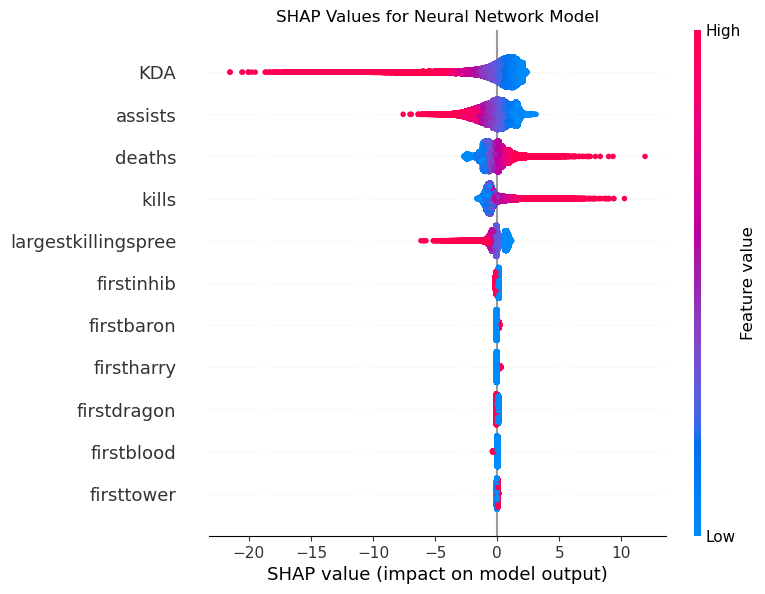

In [43]:
import matplotlib.pyplot as plt
shap.summary_plot(shap_values_nn, features=x_test_numpy, feature_names=features, show=False)
plt.title('SHAP Values for Neural Network Model')
plt.show()

In [44]:
print("Neural Network Model:")
print("Test Accuracy:", test_acc_nn)
print("Test Loss:", test_loss_nn)

Neural Network Model:
Test Accuracy: 0.2977154850959778
Test Loss: 10.202468872070312


In [ ]:
model_rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1)
model_rf.fit(x_train, y_train)

train_data_subset = train_data.loc[:, features + ["win"]]

# Convert TensorFlow tensor to pandas DataFrame with specified column names
x_train_sample_df = pd.DataFrame(x_train_sample.numpy(), columns=features)

# Create a SHAP KernelExplainer
explainer_rf = shap.KernelExplainer(model_rf.predict, x_train_sample_df,)
x_test_numpy = x_test.numpy()
# Calculate SHAP values for test data
shap_values_rf = explainer_rf.shap_values(x_test_numpy)

In [ ]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Make predictions using the RandomForestClassifier model
predictions_rf = model_rf.predict(x_test)

# Calculate accuracy
accuracy_rf = accuracy_score(predictions_rf, y_test)

# Print the accuracy
print("Random Forest Model Accuracy:", accuracy_rf)

# Plot the summary plot
shap.summary_plot(shap_values_rf, features=x_test, feature_names=features, show=False)
plt.title('SHAP Values for Random Forest Model')
plt.show()